#GDP 와 삶의 만족도 데이터셋을 활용해 1차 선형 함수 모델 학습하기


#### 설명. 아래의 예제는 1주차에 학습한 국가별 1인 GDP 에 따른 삶의 만족도를 1차 선형 함수로 모델링한 결과이다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 필요 라이브러리 불러오기
import matplotlib.font_manager as fm
import os
import matplotlib.pyplot as plt

# apt-get : 패키지 설치 명령어
# -qq : 에러외의 메세지 숨기는 옵션키
!apt-get -qq install fonts-nanum|


fe = fm.FontEntry(
    fname=r'/content/drive/MyDrive/ML/HW2/NanumGothic-Regular.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정

/bin/bash: -c: line 2: syntax error: unexpected end of file


In [3]:
import os
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import numpy as np
import pandas as pd
import sklearn.linear_model
import sklearn.neighbors

np.random.seed(42)  # 난수 생성기의 초기값 설정 (재현성 보장)

plt.rc("axes", unicode_minus=False)


def prepare_country_stats(oecd_bli, gdp_per_capita, remove_indices = [0, 1, 6, 8, 33, 34, 35], scale=1e-5):
    oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
    oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")
    gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
    gdp_per_capita.set_index("Country", inplace=True)
    full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita,
                                  left_index=True, right_index=True)
    full_country_stats.sort_values(by="GDP per capita", inplace=True)
    keep_indices = list(set(range(36)) - set(remove_indices))

    country_stats = full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices]

    country_stats["GDP per capita"] *= scale
    return country_stats

In [4]:
## 데이터 적재
oecd_bli = pd.read_csv("/content/drive/MyDrive/ML/HW2/oecd_bli_2015.csv", thousands=',')
gdp_per_capita = pd.read_csv("/content/drive/MyDrive/ML/HW2/gdp_per_capita.csv", thousands=',', delimiter='\t', encoding='latin1', na_values='n/a')

In [5]:
## 데이터 준비
country_stats = prepare_country_stats(oecd_bli, gdp_per_capita)
X = np.c_[country_stats["GDP per capita"]]
Y = np.c_[country_stats["Life satisfaction"]]

In [6]:
X.shape, Y.shape

((29, 1), (29, 1))

#### 아래의 그림의 1인당 GDP (100K $) 에 대한 삶의 만족도 를 시각화한 결과이다.

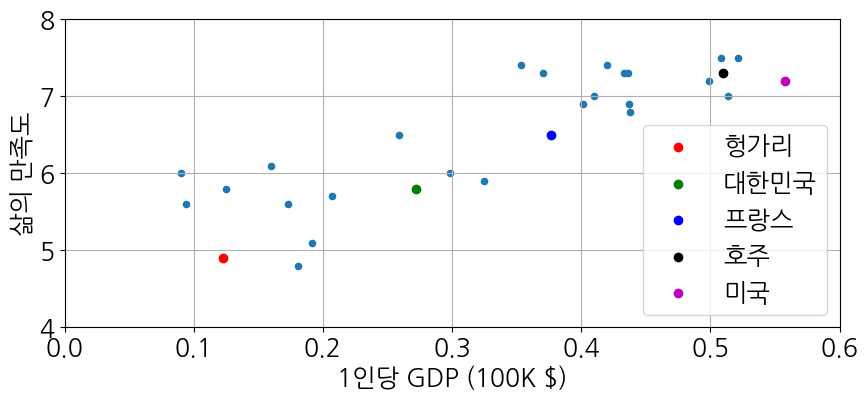

In [7]:
## 데이터 시각화
country_stats.plot(kind='scatter', x="GDP per capita", y="Life satisfaction", figsize=(10, 4))
plt.scatter(country_stats['GDP per capita']['Hungary'],         country_stats["Life satisfaction"]['Hungary'],          c='r', label='헝가리')
plt.scatter(country_stats['GDP per capita']['Korea'],           country_stats["Life satisfaction"]['Korea'],            c='g', label='대한민국')
plt.scatter(country_stats['GDP per capita']['France'],          country_stats["Life satisfaction"]['France'],           c='b', label='프랑스')
plt.scatter(country_stats['GDP per capita']['Australia'],       country_stats["Life satisfaction"]['Australia'],        c='k', label='호주')
plt.scatter(country_stats['GDP per capita']['United States'],   country_stats["Life satisfaction"]['United States'],    c='m', label='미국')
plt.ylabel('삶의 만족도')
plt.xlabel('1인당 GDP (100K $)')
plt.ylim([4, 8])
plt.xlim([0, 0.6])
plt.grid()
plt.legend()
plt.show()


#### 이를 Linear Regression 모델을 이용하여 학습하면 아래와 같은 함수를 얻을 수 있다.

#### 삶의_만족도 = weight * 1인당_GDP + bias

In [8]:
## 선형 모델 선택
model = sklearn.linear_model.LinearRegression()

## 모델 훈련
model.fit(X, Y)

weight = model.coef_[0, 0]  # 학습된 가중치 (weight)
bias = model.intercept_[0]  # 학습된 편향 (bias)

print(f'[학습된 모델] 삶의_만족도 = {weight:.2e} X 1인당_GDP + {bias:.2f}')

[학습된 모델] 삶의_만족도 = 4.91e+00 X 1인당_GDP + 4.85


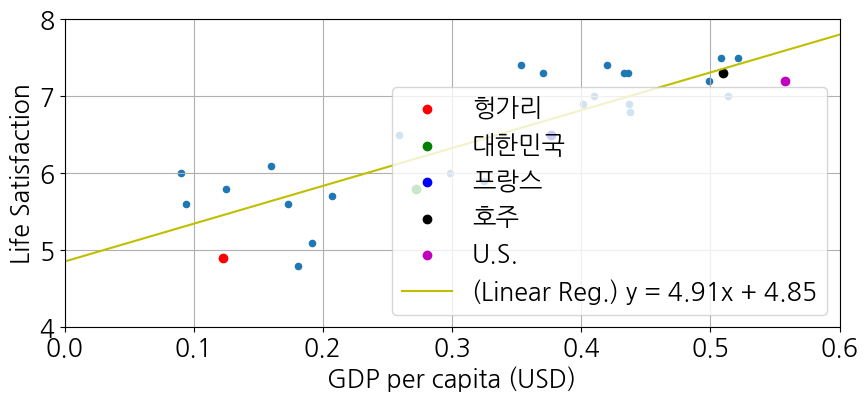

In [9]:
## 데이터 시각화
country_stats.plot(kind='scatter', x="GDP per capita", y="Life satisfaction", figsize=(10, 4))

plt.scatter(country_stats['GDP per capita']['Hungary'],         country_stats["Life satisfaction"]['Hungary'],          c='r', label='헝가리')
plt.scatter(country_stats['GDP per capita']['Korea'],           country_stats["Life satisfaction"]['Korea'],            c='g', label='대한민국')
plt.scatter(country_stats['GDP per capita']['France'],          country_stats["Life satisfaction"]['France'],           c='b', label='프랑스')
plt.scatter(country_stats['GDP per capita']['Australia'],       country_stats["Life satisfaction"]['Australia'],        c='k', label='호주')
plt.scatter(country_stats['GDP per capita']['United States'],   country_stats["Life satisfaction"]['United States'],    c='m', label='U.S.')

plt.plot(np.linspace(0, 0.6),                                 weight*np.linspace(0, 0.6) + bias,                    'y',    label=rf'(Linear Reg.) y = {weight:.2f}x + {bias:.2f}')

plt.ylabel('Life Satisfaction')
plt.xlabel('GDP per capita (USD)')
plt.ylim([4, 8])
plt.xlim([0, 0.6])
plt.grid()
plt.legend()
plt.show()


#### 문제. 아래의 `코드`를 완성하고, 그에 대한 `분석`을 작성하시오.

1. (코드) 경사 하강법을 수행하기 위해, w 와 b 의 gradient 를 구하는 함수를 작성하시오.
   - (분석) 경사 하강법에 대해 설명하고, w 와 b 에 gradient 를 계산하시오.

In [10]:
def compute_gradients(X, Y, w, b):
    y_pred = w * X + b
    error = y_pred - Y

    w_gradient = 2 * error * X
    b_gradient = 2 * error

    return w_gradient, b_gradient

m = len(X)
total_w_gradient = 0
total_b_gradient = 0

# 각 샘플에 대해 기울기를 계산하고 누적
for epoch in range(m):
    x = X[epoch][0]
    y = Y[epoch][0]
    w_gradient, b_gradient = compute_gradients(x, y, weight, bias)

    # 각 샘플의 기울기를 누적
    total_w_gradient += w_gradient
    total_b_gradient += b_gradient

# 기울기의 평균을 계산
avg_w_gradient = total_w_gradient / m
avg_b_gradient = total_b_gradient / m

print("Average w_gradient:", avg_w_gradient)
print("Average b_gradient:", avg_b_gradient)

Average w_gradient: 1.550483879217891e-16
Average b_gradient: 5.512831570552502e-16


2. (코드) 사용되는 변수들을 초기화 (initialization) 하시오.
   - (분석) 사용되는 변수들에 대해 설명하시오.

In [11]:
random_num1 = np.random.randn(1)
random_num2 = random_num1[0]
print('Number : ',random_num1, ', Type : ', type(random_num1))
print('Number : ',random_num2, ', Type : ', type(random_num2))

Number :  [0.49671415] , Type :  <class 'numpy.ndarray'>
Number :  0.4967141530112327 , Type :  <class 'numpy.float64'>


In [12]:
print(weight, bias)

4.911544589158483 4.853052800266436


In [13]:
# 모델 파라미터 초기화
w = np.random.randn(1)[0]
b = np.random.randn(1)[0]
#w = weight
#b = bias
print('w : ',w,',b : ',b)
n_epochs = 30 #학습 횟수
eta = 0.1 #학습률
np.random.seed(42)
#난수 생성기의 초깃값 설정

w :  -0.13826430117118466 ,b :  0.6476885381006925


3. (코드) 확률적 경사 하강법 (Stocastic Gradient Descent Method) 를 이용하여, 1차원 선형 함수를 학습하시오.
   - (분석) 상세히 주석을 작성하시오.

In [14]:
lst_w = []
lst_b = []
lst_loss = []

lst_w.append(w)
lst_b.append(b)

random_index = list(range(len(X)))

# Stochastic Gradient Descent (SGD) 수행
for epoch in range(n_epochs):  # 각 epoch 반복
    np.random.shuffle(random_index)
    lst_part_w=[]
    lst_part_b=[]
    lst_part_loss = []
    for i in random_index:  # 각 데이터 포인트에 대해 반복

        # 데이터 불러오기
        x = X[i][0]
        y = Y[i][0]

        w_gradient, b_gradient = compute_gradients(x, y, w, b)
        w = w - eta * w_gradient
        #b = b - eta * b_gradient
        loss = (w * x + b - y) ** 2

        # 파라메터 누적하기
        lst_part_w.append(w)
        lst_part_b.append(b)
        lst_part_loss.append(loss)

    lst_w.append(np.mean(lst_part_w))
    lst_b.append(np.mean(lst_part_b))
    lst_loss.append(np.mean(lst_part_loss))

#### (수정하지 마시오.) 결과 출력

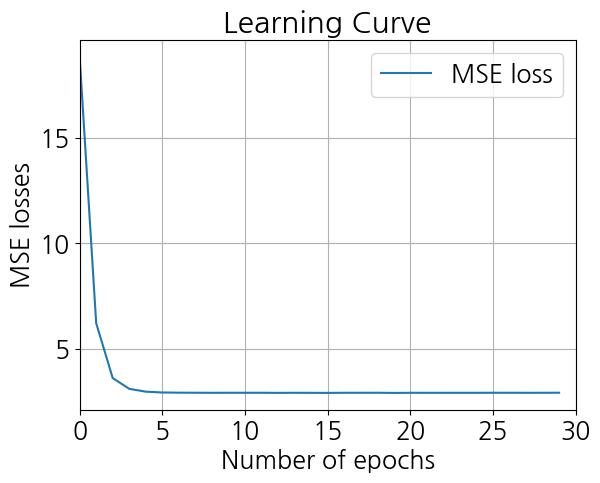

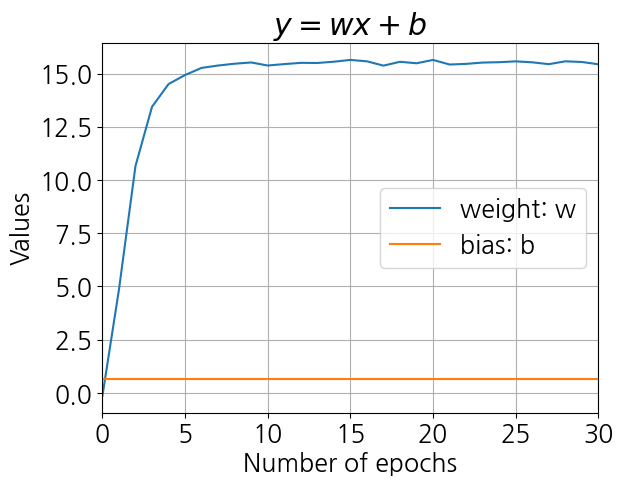

In [15]:
plt.plot(lst_loss, label='MSE loss')
plt.legend()
plt.grid()
plt.xlim([0, n_epochs])
plt.title('Learning Curve')
plt.xlabel('Number of epochs')
plt.ylabel('MSE losses')
plt.show()

plt.plot(lst_w, label='weight: w')
plt.plot(lst_b, label='bias: b')
plt.legend()
plt.grid()
plt.xlim([0, n_epochs])
plt.title('$y = wx + b$')
plt.xlabel('Number of epochs')
plt.ylabel('Values')
plt.show()

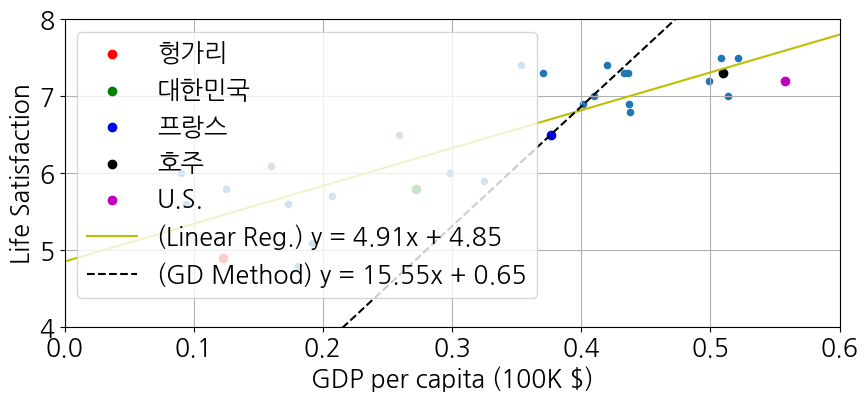

In [16]:
## 데이터 시각화
country_stats.plot(kind='scatter', x="GDP per capita", y="Life satisfaction", figsize=(10, 4))

plt.scatter(country_stats['GDP per capita']['Hungary'],         country_stats["Life satisfaction"]['Hungary'],          c='r', label='헝가리')
plt.scatter(country_stats['GDP per capita']['Korea'],           country_stats["Life satisfaction"]['Korea'],            c='g', label='대한민국')
plt.scatter(country_stats['GDP per capita']['France'],          country_stats["Life satisfaction"]['France'],           c='b', label='프랑스')
plt.scatter(country_stats['GDP per capita']['Australia'],       country_stats["Life satisfaction"]['Australia'],        c='k', label='호주')
plt.scatter(country_stats['GDP per capita']['United States'],   country_stats["Life satisfaction"]['United States'],    c='m', label='U.S.')

plt.plot(np.linspace(0, 0.6),                                 weight*np.linspace(0, 0.6) + bias,                    'y',    label=rf'(Linear Reg.) y = {weight:.2f}x + {bias:.2f}')
plt.plot(np.linspace(0, 0.6),                                 w*np.linspace(0, 0.6) + b,                            'k--',  label=rf'(GD Method) y = {w:.2f}x + {b:.2f}')

plt.ylabel('Life Satisfaction')
plt.xlabel('GDP per capita (100K $)')
plt.ylim([4, 8])
plt.xlim([0, 0.6])
plt.grid()
plt.legend()
plt.show()


4. (코드) weight 와 bias 의 초기값, epoch 의 횟수, 그리고 학습률 (learning rate) 등을 변경해가며 위의 결과 출력을 수행하시오.
   - (분석) weight 와 bias 의 초기값, epoch 의 횟수, 그리고 학습률 (learning rate) 등이 달라짐에 따라, 어떤 변화가 있는 관측하고 분석하시오.

<h1>weight와 bias의 초깃값 기준 분석</h1>

1. weight,bias를 랜덤으로 초기화한 경우

MSE가 점진적으로 감소하면서 안정적 수렴


```
# 모델 파라미터 초기화
w = np.random.randn(1)[0]
b = np.random.randn(1)[0]
#w = weight
#b = bias
n_epochs = 30 #학습 횟수
eta = 0.1 #학습률
np.random.seed(42)
```

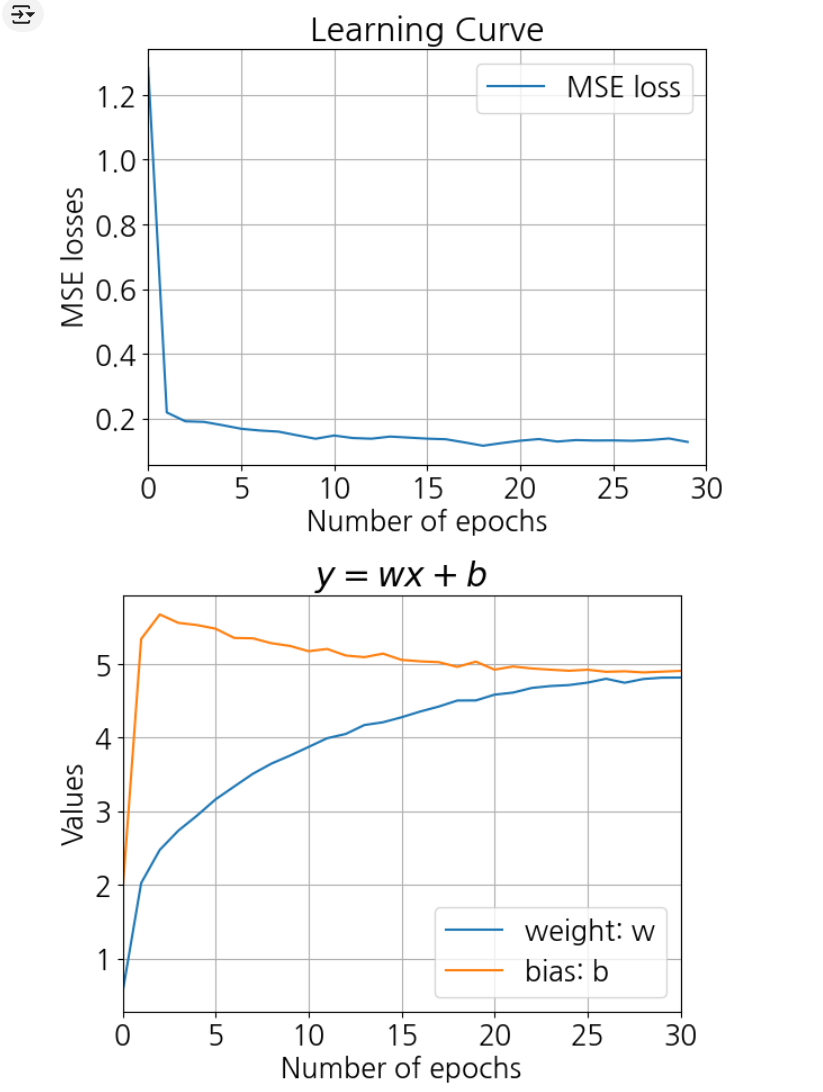

2. 선형 모델 훈련된 weight, bias로 설정한 경우

MSE가 낮은 값에서 시작하지만 손실이 불안정하게 진동

이미 최적점에 근접해 있는 값, 진동하는 경향


```
# 모델 파라미터 초기화
#w = np.random.randn(1)[0]
#b = np.random.randn(1)[0]
w = weight
b = bias
print('w : ',w,',b : ',b)
n_epochs = 30 #학습 횟수
eta = 0.1 #학습률
np.random.seed(42)
```

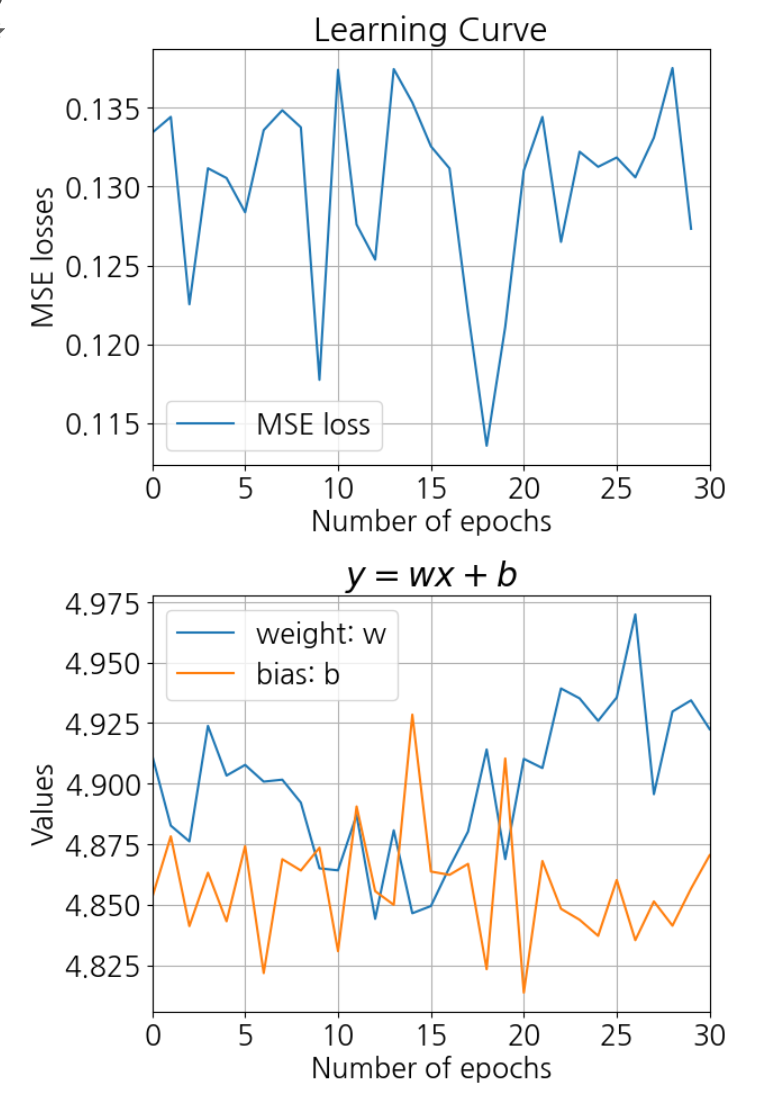

<h1>epoch의 횟수</h1>

1. epoch가 10번인 경우

모델이 최적의 값에 수렴하기도 전에 멈춰 버림

```
# 모델 파라미터 초기화
w = np.random.randn(1)[0]
b = np.random.randn(1)[0]
#w = weight
#b = bias
print('w : ',w,',b : ',b)
n_epochs = 10 #학습 횟수
eta = 0.1 #학습률
np.random.seed(42)
#난수 생성기의 초깃값 설정
```

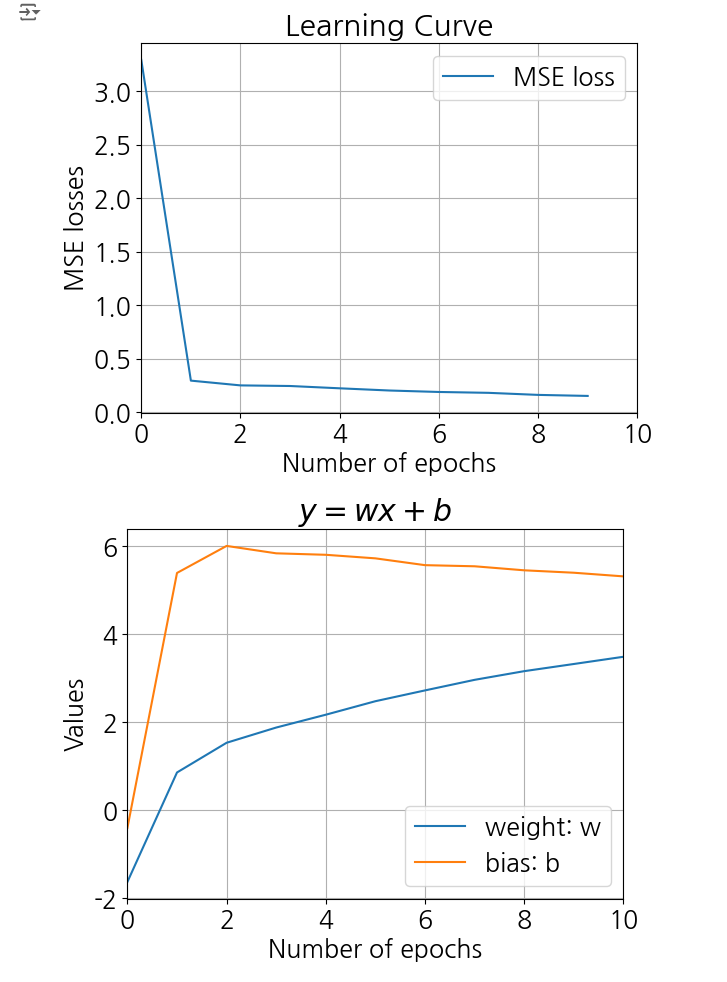

2. epoch이 300번인 경우

모델이 최적의 파라미터에 수렴한 이후에 계속 학습

```
# 모델 파라미터 초기화
w = np.random.randn(1)[0]
b = np.random.randn(1)[0]
#w = weight
#b = bias
print('w : ',w,',b : ',b)
n_epochs = 300 #학습 횟수
eta = 0.1 #학습률
np.random.seed(42)
#난수 생성기의 초깃값 설정
```



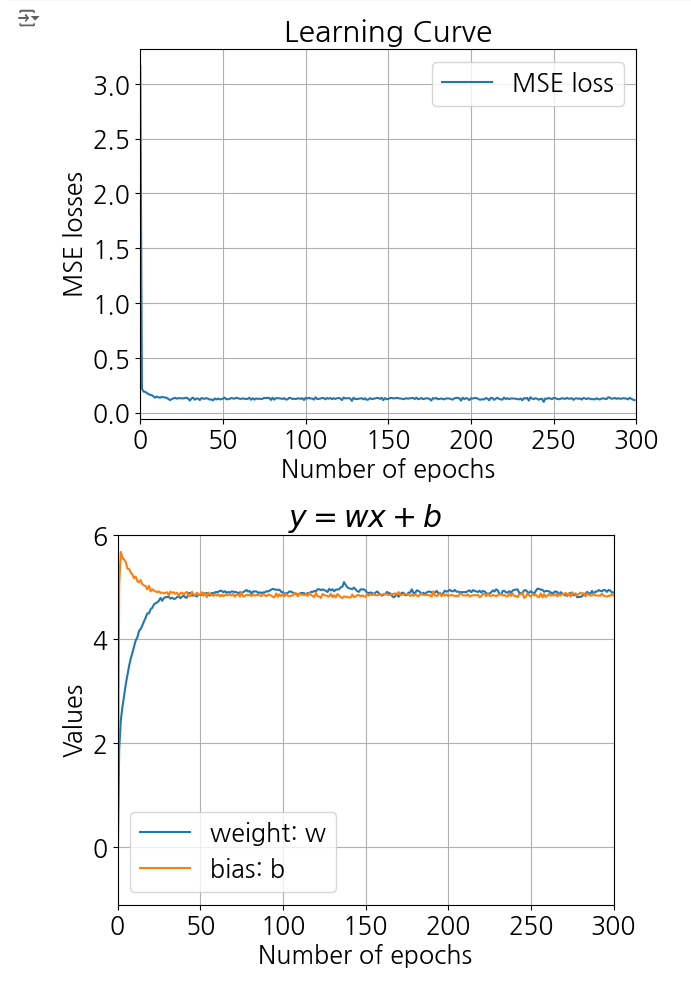

<h1>학습률(learning rate) 기준 분석</h1>

1. learning rate가 0.5인경우

빠르게 파라미터에 수렴하여 진동

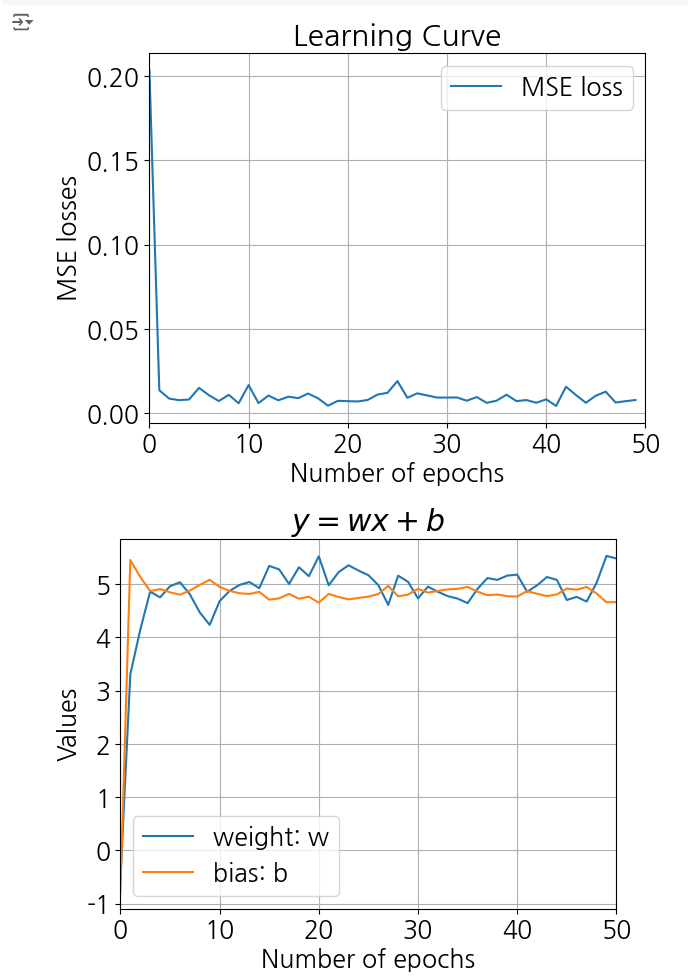

2. learning rate가 0.01인 경우

파라미터가 업데이트 되지만 매우 느린 속도

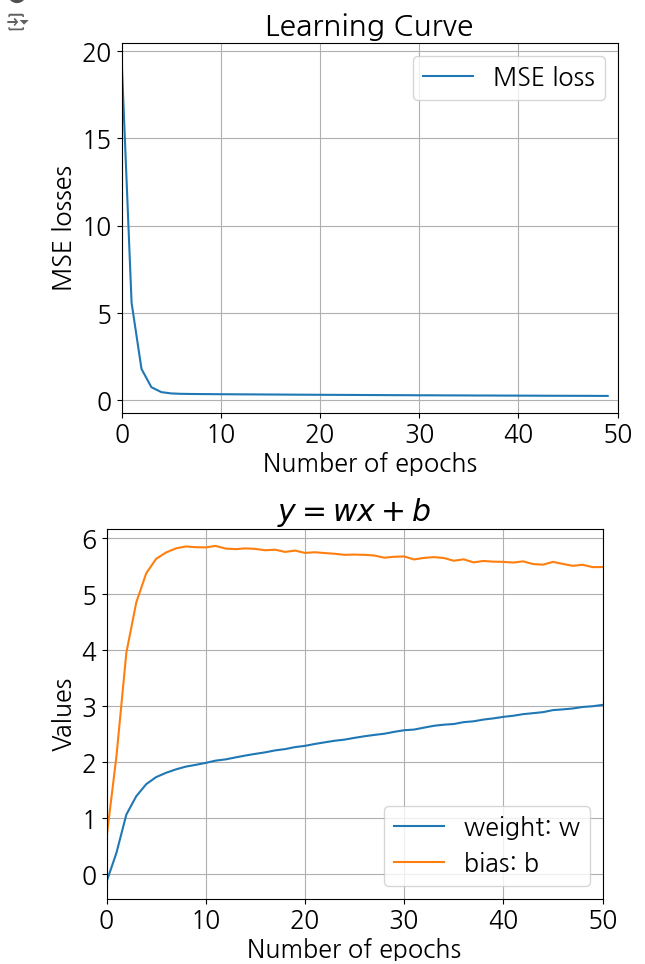